In [1]:
dataset_name = "ibm-common-stock-closing-prices"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import matplotlib.pyplot as plt
import holidays
import joblib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess Dataset

In [3]:
data = pd.read_csv(path,header=0)
data["Date"] = pd.to_datetime(data["Date"],format="%Y-%m-%d")

data["timestamp"] = data["Date"]
del data["Date"]
data["value"] = data["IBM common stock closing prices"]
del data["IBM common stock closing prices"]

start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

missing = adclasses.find_missing_time_steps(start_date, end_date, '1D', data)
print("Missing time steps: ", missing)

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="1D", dateformat="%Y-%m-%d", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())

true_outlier_dates = ["1965-06-08 00:00:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  1962-01-02T00:00:00.000000000
End date:  1965-12-31T00:00:00.000000000
Missing time steps:  DatetimeIndex(['1962-01-06', '1962-01-07', '1962-01-13', '1962-01-14',
               '1962-01-20', '1962-01-21', '1962-01-27', '1962-01-28',
               '1962-02-03', '1962-02-04',
               ...
               '1965-11-28', '1965-12-04', '1965-12-05', '1965-12-11',
               '1965-12-12', '1965-12-18', '1965-12-19', '1965-12-24',
               '1965-12-25', '1965-12-26'],
              dtype='datetime64[ns]', length=452, freq=None)
Length:  1460
Time step size:  1D
Start Date:  1962-01-02T00:00:00.000000000
End Date:  1965-12-31T00:00:00.000000000
Date Format:  %Y-%m-%d
True outlier indices:  [1253]


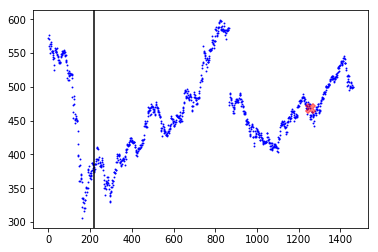

In [4]:
ad.plot_outliers([], true_outlier_indices)

# SARIMA


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : 1702.721
 ARIMA(1,0,0) with non-zero mean : 1372.582
 ARIMA(0,0,1) with non-zero mean : -7603.707
 ARIMA(0,0,0) with zero mean     : 1699.554
 ARIMA(1,0,1) with non-zero mean : -12568.15
 ARIMA(2,0,1) with non-zero mean : -7916.4
 ARIMA(1,0,2) with non-zero mean : -12937.16
 ARIMA(0,0,2) with non-zero mean : -9298.27
 ARIMA(1,0,3) with non-zero mean : Inf
 ARIMA(0,0,3) with non-zero mean : -7383.908
 ARIMA(2,0,3) with non-zero mean : Inf
 ARIMA(1,0,2) with zero mean     : -4835.711

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,2) with non-zero mean : 1183.494

 Best model: Regression with ARIMA(1,0,2) errors 



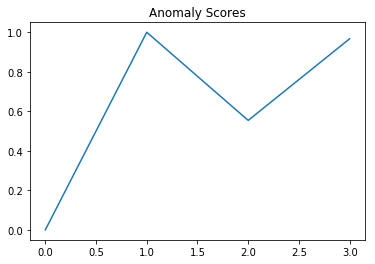

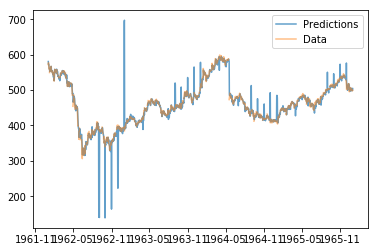

Time:  9.862492561340332


['anomaly_scores/SARIMA_auto/ibm-common-stock-closing-prices_no_fill']

In [5]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name+ "_no_fill"
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Prophet

In [6]:
# optimization step

step_sizes = [100, 200]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for changepoint_prior_scale in changepoint_prior_scales:

        mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=changepoint_prior_scale,
                                  step_size=step_size,
                                  optimize=True)
        print("Step Size: ", step_size)
        print("Changepoint Prior Scale: ", changepoint_prior_scale)
        print("MSE: ",mse)

        key_str = "Step Size " + str(step_size) +" Changepoint Prior Scale" + str(changepoint_prior_scale)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.01
MSE:  1219.0175888574395


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.05
MSE:  514.4179343539265


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.1
MSE:  400.3759619026853


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.15
MSE:  299.98990067472465


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.2
MSE:  311.24846732086024


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.01
MSE:  1219.0175888574395


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.05
MSE:  514.4179343539265


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.1
MSE:  400.3759619026853


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.15
MSE:  299.98990067472465
Step Size:  200
Changepoint Prior Scale:  0.2
MSE:  311.24846732086024

best params:  Step Size 100 Changepoint Prior Scale0.15


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


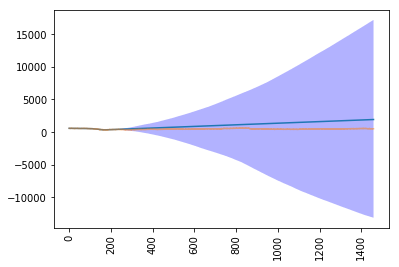

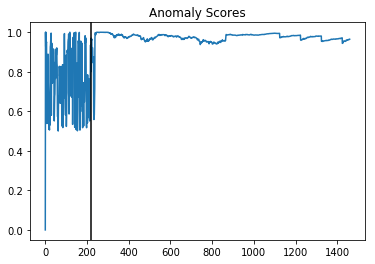

Time:  5.667728424072266


['anomaly_scores/Prophet/ibm-common-stock-closing-prices_no_fill']

In [7]:
save_path = "anomaly_scores/Prophet/" + dataset_name+ "_no_fill"
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=.15,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# GLM

In [8]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

100%|██████████| 1008/1008 [00:00<00:00, 13834.57it/s]

Initial Mean 438.9940182648402
Initial StdDev 85.26794927572575



100%|██████████| 1008/1008 [00:00<00:00, 13989.71it/s]

eta:  0.5
lambda:  0.99
MSE:  1545.9250273794992
Initial Mean 438.9940182648402
Initial StdDev 85.26794927572575



100%|██████████| 1008/1008 [00:00<00:00, 14812.92it/s]

eta:  0.5
lambda:  0.999
MSE:  4314.20313147346
Initial Mean 438.9940182648402
Initial StdDev 85.26794927572575



100%|██████████| 1008/1008 [00:00<00:00, 10807.63it/s]

eta:  0.5
lambda:  0.9999
MSE:  4773.541092113325
Initial Mean 438.9940182648402
Initial StdDev 85.26794927572575



  0%|          | 0/1008 [00:00<?, ?it/s]

eta:  1
lambda:  0.99
MSE:  793.4037266275018
Initial Mean 438.9940182648402
Initial StdDev 85.26794927572575
eta:  1
lambda:  0.999
MSE:  3082.189800036784
Initial Mean 438.9940182648402
Initial StdDev 85.26794927572575


100%|██████████| 1008/1008 [00:00<00:00, 20980.89it/s]

eta:  1
lambda:  0.9999
MSE:  3655.213924973806

best params:  eta 1 lambda 0.99


100%|██████████| 1008/1008 [00:00<00:00, 14233.15it/s]


Initial Mean 438.9940182648402
Initial StdDev 85.26794927572575


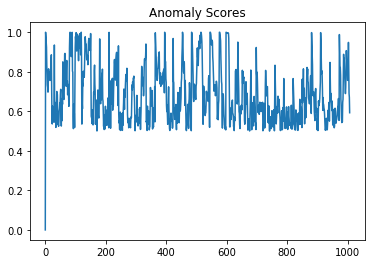

Time:  0.23783063888549805


['anomaly_scores/GLM/ibm-common-stock-closing-prices_no_fill']

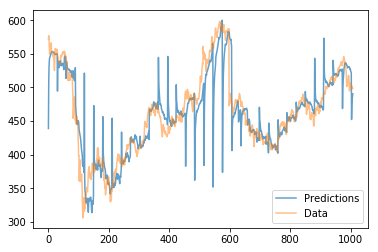

In [9]:
save_path = "anomaly_scores/GLM/" + dataset_name+ "_no_fill"
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=1, lambda_=0.99,plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# STL Resid

In [10]:
# no seasonality so no stl